

---



# HDAT9900: Dissertation (Part 2)


#### Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
# Change directory and link to google drive
cd drive

[Errno 2] No such file or directory: 'drive'
/content/drive


In [6]:
cd My Drive

/content/drive/My Drive


In [7]:
cd 5_Code

/content/drive/My Drive/5_Code


In [8]:
ls

01-prepare-data.ipynb  data/      plan-violation/  standardisation.ipynb
02-models.ipynb        model.png  __pycache__/     tests/


#### Dependencies

In [2]:
import numpy as np
import pandas as pd

#cnn
from keras.optimizers import Adam
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization

# rnn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

# combined model
from keras.utils import plot_model

# evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Set seed
seeds = 0

'\n#cnn\nfrom keras.optimizers import Adam\nfrom keras.layers import Conv3D, MaxPool3D, Flatten, Dense\nfrom keras.layers import Dropout, BatchNormalization\n\n# rnn\nfrom keras.preprocessing.text import Tokenizer\nfrom keras.preprocessing.sequence import pad_sequences\nfrom keras.layers import Dense, Embedding, LSTM, SpatialDropout1D\nfrom keras.callbacks import EarlyStopping\n\n# combined model\nfrom keras.utils import plot_model\n\n# evaluation\nfrom sklearn.metrics import accuracy_score\nfrom sklearn.metrics import classification_report\n\n# Set seed\nseeds = 0\n'

## 2. Build Models

Let's load the data that we prepared in part 1. We will also reshape the voxel data from a flattened 7698x4096 to a 3D voxel structure of height x width x depth x channels (16x16x16x1).

### 2.1. Load data

In [81]:
# 2.1. load data -------------------------------------------------------------------
filenames_y = pd.read_csv('data/processed/dataset2labelsorgansclean.csv')
X_cnn = np.load('data/processed/dataset2voxels16.npy')
X_rnn = filenames_y['organs']
#y_orig = filenames_y['class7']
#k=8
y_orig = filenames_y['class13'] # actually 18 different organs
k=18

# 2.1.2. prepare cnn data ------------------------------------------------------------
size = 16
h, w, d = size, size, size
c = 1  # Channels 1 = grey scale, 3 = colour

#taking random indices to split the dataset into train and test
test_ids = np.random.permutation(X_cnn.shape[0])

#splitting data and labels into train and test
#keeping last 10 entries for testing, rest for training

X_train_cnn = X_cnn[test_ids[:-int(np.ceil(X_cnn.shape[0]*0.25))]]
X_test_cnn = X_cnn[test_ids[-int(np.ceil(X_cnn.shape[0]*0.25)):]]

X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], h, w, d, c)
X_test_cnn = X_test_cnn.reshape(X_test_cnn.shape[0], h, w, d, c)

# 2.1.3. prepare rnn data ---------------------------------------------------------

MAX_NB_CHARS = 26
MAX_SEQUENCE_LENGTH = 5
EMBEDDING_DIM = 20

# 2.1.3.1 Tokenize the data
tokenizer = Tokenizer(num_words=MAX_NB_CHARS,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True,
                      char_level=True)
tokenizer.fit_on_texts(y_orig)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_rnn = tokenizer.texts_to_sequences(y_orig)
X_rnn = pad_sequences(X_rnn, maxlen=MAX_SEQUENCE_LENGTH)
X_train_rnn = X_rnn[test_ids[:-int(np.ceil(X_cnn.shape[0]*0.25))]]
X_test_rnn = X_rnn[test_ids[-int(np.ceil(X_cnn.shape[0]*0.25)):]]

# 2.1.4. prepare the labels ------------------------------------------------------
y = pd.get_dummies(y_orig).values
# last 75/25 split
y_train = y[test_ids[:-int(np.ceil(X_cnn.shape[0]*0.25))]]
y_test = y[test_ids[-int(np.ceil(X_cnn.shape[0]*0.25)):]]
# tags
my_tags = sorted([i for i in set(y_orig)])

# 2.1.5. checks -----------------------------------------------------------------
print("CNN train shape: \t", X_train_cnn.shape)
print("RNN train shape: \t", X_train_rnn.shape)
print("Label train shape: \t", y_train.shape)
print("\n")
print("CNN test shape: \t", X_test_cnn.shape)
print("RNN test shape: \t", X_test_rnn.shape)
print("Label test shape: \t", y_test.shape)

Found 24 unique tokens.
CNN train shape: 	 (5773, 16, 16, 16, 1)
RNN train shape: 	 (5773, 5)
Label train shape: 	 (5773, 18)


CNN test shape: 	 (1925, 16, 16, 16, 1)
RNN test shape: 	 (1925, 5)
Label test shape: 	 (1925, 18)


---
### 2. 2. 1. 3D Convolutional Neural Network (CNN)

Description of CNN. 

In [0]:
# ==============================================================================
# 2.2.1. Convolutional Neural Network
# ==============================================================================

def CNN(X_train, X_test, y_train, y_test, k, my_tags):
    
    # Hyper parameters ---------------------------------------------------------
    max_epochs = 25
    batch_size = 128
    dropout_rate=0.5

    # Optimizers
    # from keras.optimizers import SGD
    # opt = Adadelta(lr=0.001)
    opt = Adam(lr=0.01, decay=0.7)
    # opt = SGD(lr=0.001, momentum=0.9)

    # Model Architecture -------------------------------------------------------
    
    model = Sequential()
    # Convolution layers
    model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu',\
                     input_shape=(h, w, d, c)))
    model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu'))
    # Add max pooling to obtain the most informative features
    model.add(MaxPool3D(pool_size=(2, 2, 2)))

    # Convolution layers
    model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu'))
    model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
    # Add max pooling to obtain the most informative features
    model.add(MaxPool3D(pool_size=(2, 2, 2)))

    # perform batch normalization on the convolution outputs before
    # feeding it to MLP architecture
    model.add(BatchNormalization())
    model.add(Flatten())

    # create an MLP architecture with dense layers : 4096 -> 512 -> 10
    # add dropouts to avoid over-fitting / perform regularization
    model.add(Dense(units=(h*w*d), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(units=k, activation='softmax'))

    # Compile
    model.compile(loss='categorical_crossentropy', optimizer=opt, \
                  metrics=['accuracy'])
    model.summary()

    print("\n####################### Training Model #############################")
    print("Training...")
    history = model.fit(x=X_train, y=y_train,
                        batch_size=batch_size,
                        epochs=max_epochs,
                        validation_split=0.1,
                        verbose=1)

    # ==========================================================================
    # 3. Results
    # ==========================================================================
    print("###################################################################")
    print("\nResults:\n")
    accr = model.evaluate(X_test, y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],
                                                                  accr[1]))
    print("-------------------------------------------------------------------")
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show();

    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='test')
    plt.legend()
    plt.show();
    print("###################################################################")
    
    # Make predictions 
    y_pred = model.predict(X_test)

    # evaluate the model
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))
    print("\n####################################################################")

    # Classification report
    report = classification_report(y_test, y_pred.round(), target_names=my_tags)
    #report = classification_report(y_test, y_pred.round())
    print("\nClassfication Report for test:\n", report)
    print("\n####################################################################")
    
    return(model, report)



---
### Document classification (Recurrent Neural Network)

In order to improve the performance of our model, we will also utilise the name of which the clinician named the 3D file (organ). This name will then be fed into the NN to give further information.

Help: https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a


"Recurrent Neural Networks (RNNs) adopt the same principle, albeit in an extremely simplified version: they process sequences by iterating through the sequence elements and maintaining a "state" containing information relative to what they have seen so far. In effect, RNNs are a type of neural network that has an internal loop (Figure 6.8). The state of the RNN is reset in-between processing two different, independent sequences (e.g. two different IMDB reviews), so we still consider one sequence as a single datapoint, a single input to the network—what changes is that this datapoint is no longer processed in a single step, rather, the network internally loops over sequence elements. " 

### LSTM for name classification

Based on the filename of the organ named by the clinician, we will create a Recurrent Neural Network (RNN) using the Long Short Term Memory (LSTM) architecture to predict what the organ is. 

* Vectorize file names by turning each word into either a sequence of integers or into a vector.
* Limit the data set to the top 1000 words.
* Set the max number of words in each file to 20.

In [0]:
def rnn(X_train, X_test, Y_train, Y_test, k, my_tags):
    print("Building Document Classifier... \n")
    # 0. Hyperparameters -------------------------------------------------------
    # The maximum number of words to be used
    MAX_NB_WORDS = 26

    # Max number of words in each file name
    MAX_SEQUENCE_LENGTH = 5

    # This is fixed.
    EMBEDDING_DIM = 20

    epochs = 25
    batch_size = 32

    '''
    # 1. Tokenize the data -----------------------------------------------------
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, char_level=True)
    tokenizer.fit_on_texts(name_df['synthetic'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    X = tokenizer.texts_to_sequences(name_df['synthetic'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)

    Y = pd.get_dummies(name_df['tags']).values
    print('Shape of label tensor:', Y.shape)

    # 2. Split the data --------------------------------------------------------
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
    print(X_train.shape,Y_train.shape)
    print(X_test.shape,Y_test.shape)

    '''
    # 3. Build the model -------------------------------------------------------
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    # add dense layer to add to cnn
    model.add(Dense(k, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    print(model.summary())
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss',
                                                 patience=3, min_delta=0.0001)])

    # 4. Results ---------------------------------------------------------------
    print("###################################################################")
    print("\nResults:\n")
    accr = model.evaluate(X_test, Y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],
                                                                  accr[1]))
    print("-------------------------------------------------------------------")
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show();

    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='test')
    plt.legend()
    plt.show();
    
    # Make predictions 
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred.round(), target_names=my_tags)
    print("\nClassfication Report for test:\n", report)
    print("###################################################################")
    
    return(model)

---
### Combined (CNN + RNN)

We want to create a model that takes the organ structure from the ply for the CNN and add information from the predicted RNN to help the model become more accurate. 

This model will take the 3D model of the organ and its filename and learn about the two concurrently. 

In [0]:
from keras.layers import Conv3D, MaxPooling3D, Flatten
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model, Sequential
import keras
import matplotlib.pyplot as plt

def standardisation_model(X_train_cnn, X_train_rnn, X_test_cnn, X_test_rnn, y_train, y_test, k, my_tags):
    
    # Hyperparameters ----------------------------------------------------------
    dropout_rate=0.5
    epochs=25
    batch_size=128
    
    # First, let's define a vision model using a Sequential model.
    # This model will encode an image into a vector.
    vision_model = Sequential()
    vision_model.add(Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', input_shape=(h, w, d, c)))
    vision_model.add(Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu'))
    vision_model.add(MaxPool3D(pool_size=(2, 2, 2)))
    vision_model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu'))
    vision_model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
    vision_model.add(MaxPool3D(pool_size=(2, 2, 2)))
    vision_model.add(BatchNormalization())
    vision_model.add(Flatten())
    vision_model.add(Dense(units=(h*w*d), activation='relu'))
    vision_model.add(Dropout(dropout_rate))
    vision_model.add(BatchNormalization())
    vision_model.add(Dense(units=512, activation='relu'))
    vision_model.add(Dropout(dropout_rate))
    vision_model.add(BatchNormalization())

    # Now let's get a tensor with the output of our vision model:
    cnn_inputs = Input(shape=(h, w, d, c))
    encoded_image = vision_model(cnn_inputs)

    # Next, let's define a language model to encode the filename into a vector.
    # Each filename will be at most 20 characters long,
    # and we will index words as integers from 1 to 99.
    filename_inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_filename = Embedding(input_dim=MAX_NB_CHARS, output_dim=MAX_SEQUENCE_LENGTH, input_length=MAX_SEQUENCE_LENGTH)(filename_inputs)
    embedded_filename = SpatialDropout1D(0.2)(embedded_filename)
    encoded_filename = LSTM(100)(embedded_filename)

    # Let's concatenate the filename vector and the image vector:
    merged = keras.layers.concatenate([encoded_filename, encoded_image])

    # And let's train a logistic regression over 100 words on top:
    output = Dense(k, activation='softmax')(merged)

    # This is our final model:
    vqa_model = Model(inputs=[cnn_inputs, filename_inputs], outputs=output)

    vqa_model.compile(loss='categorical_crossentropy', optimizer='adam',
                      metrics=['accuracy'])
    vqa_model.summary()
    
    history = vqa_model.fit([X_train_cnn, X_train_rnn], y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[EarlyStopping(monitor='val_loss',
                                                 patience=3, 
                                                 min_delta=0.0001)])
    plot_model(vqa_model, to_file='model.png')

    print("###################################################################")
    print("\nResults:\n")
    accr = vqa_model.evaluate([X_test_cnn, X_test_rnn], y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],
                                                                  accr[1]))
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Make predictions 
    y_pred = vqa_model.predict([X_test_cnn, X_test_rnn])
    report = classification_report(y_test, y_pred.round(), target_names=my_tags)
    print("\nClassfication Report for test:\n", report)
    print("###################################################################")
    return(vqa_model)

---
### Build Reference Model (KNN)

The reference model is a k-nearest-neighbours model. 

Description

In [0]:
# ==============================================================================
# KNN Reference model
# ==============================================================================

def knn(X,y):
    '''
    This is a reference model for the dissertation-standardisation task
    The dimensionality for the feature set currently is (1716, 4096)
    Where each row represents an organ of which has been reshaped into a 1d V
    Performance will be compared to a 3D convolutional neural network
    '''
    print("\n####################################################################")
    print("Building KNN Reference Model")

    # Dependencies ------------------------------------------------------------
    import numpy as np
    from sklearn.metrics import classification_report
    # Load data ---------------------------------------------------------------
    print("Loading data...")
    print('X shape is: ', X.shape)
    print('y shape is: ', y.shape)
    
    # Split the data ----------------------------------------------------------
    print("Splitting the data...")
    from sklearn.model_selection import train_test_split
    #split data into 1: train+validation set and 2: test set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seeds, test_size=0.25)
    

    # Build model -------------------------------------------------------------
    print("Building model...")
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier()
    print("Training model...")
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Evaluation --------------------------------------------------------------
    print("Evaluation -------------------------------------------------------")
    print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))
    #Classification report ----------------------------------------------------
    report = classification_report(y_test, y_pred.round(),\
                                   target_names=my_tags)
    print("\nClassfication Report for test:\n", report)
    print("\n####################################################################")
    return(knn, report)


### Run Models

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_47 (Conv3D)           (None, 14, 14, 14, 8)     224       
_________________________________________________________________
conv3d_48 (Conv3D)           (None, 12, 12, 12, 16)    3472      
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 6, 6, 6, 16)       0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 4, 4, 4, 32)       13856     
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 1, 1, 1, 64)       0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 1, 1, 1, 64)       256       
__________

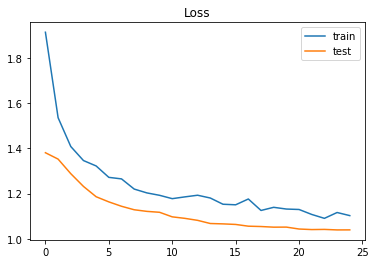

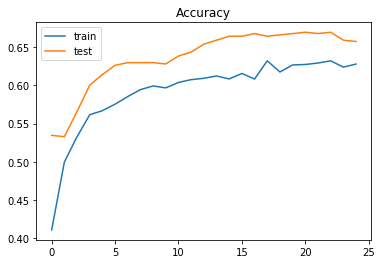

###################################################################

Train: 0.672, Test: 0.681

####################################################################

Classfication Report for test:
                     precision    recall  f1-score   support

              Apex       0.00      0.00      0.00         5
           Bladder       0.69      0.68      0.68        81
     Bladder noisy       0.00      0.00      0.00        50
              Body       0.96      0.99      0.97        69
               CTV       0.65      0.46      0.54       269
             Crura       0.00      0.00      0.00         7
      Femoral head       0.98      0.93      0.95        55
 Femoral head left       0.95      0.97      0.96        75
Femoral head right       0.98      0.94      0.96        66
               GTV       0.00      0.00      0.00        25
          Hydrogel       0.00      0.00      0.00         9
             Other       0.76      0.46      0.57       656
          Prostate   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [86]:
cnn, cnn_report = CNN(X_train_cnn, X_test_cnn, y_train, y_test, k, my_tags = my_tags)

Building Document Classifier... 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 5, 20)             520       
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 5, 20)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               48400     
_________________________________________________________________
dense_40 (Dense)             (None, 18)                1818      
Total params: 50,738
Trainable params: 50,738
Non-trainable params: 0
_________________________________________________________________
None
Train on 5195 samples, validate on 578 samples
Epoch 1/25
5195/5195 [==============================] - 8s 2ms/step - loss: 1.7428 - acc: 0.5039 - val_loss: 0.9178 - val_acc: 0.7578
Epoch 2/25
5195/5195 [============================

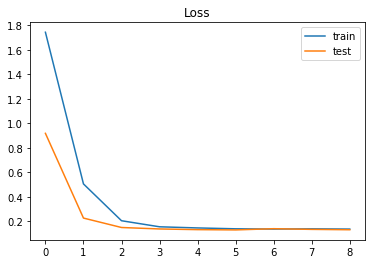

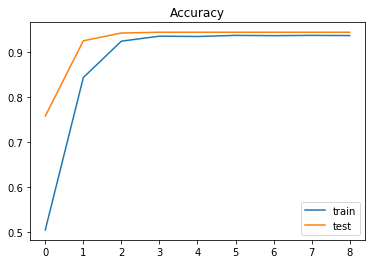


Classfication Report for test:
                     precision    recall  f1-score   support

              Apex       1.00      1.00      1.00         5
           Bladder       1.00      1.00      1.00        81
     Bladder noisy       0.00      0.00      0.00        50
              Body       1.00      1.00      1.00        69
               CTV       1.00      1.00      1.00       269
             Crura       1.00      1.00      1.00         7
      Femoral head       1.00      1.00      1.00        55
 Femoral head left       1.00      1.00      1.00        75
Femoral head right       1.00      1.00      1.00        66
               GTV       1.00      1.00      1.00        25
          Hydrogel       1.00      1.00      1.00         9
             Other       1.00      1.00      1.00       656
          Prostate       1.00      1.00      1.00       123
    Prostate noisy       0.00      0.00      0.00        60
            Rectum       1.00      1.00      1.00        91
      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [87]:
rnn = rnn(X_train_rnn, X_test_rnn, y_train, y_test, k, my_tags=my_tags)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 5, 5)         130         input_12[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_10 (SpatialDr (None, 5, 5)         0           embedding_10[0][0]               
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 16, 16, 16, 1 0                                            
__________________________________________________________________________________________________
lstm_10 (L

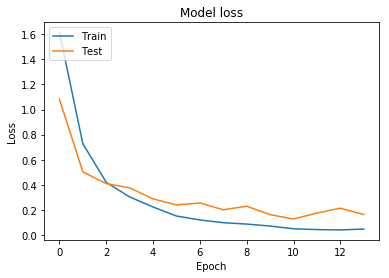

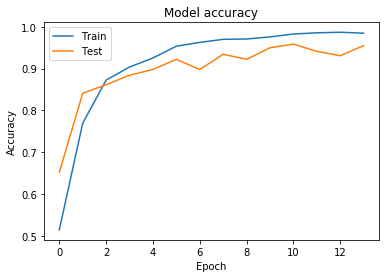


Classfication Report for test:
                     precision    recall  f1-score   support

              Apex       0.67      0.80      0.73         5
           Bladder       0.89      0.96      0.92        81
     Bladder noisy       0.72      0.82      0.77        50
              Body       0.96      1.00      0.98        69
               CTV       0.95      0.92      0.94       269
             Crura       1.00      0.57      0.73         7
      Femoral head       0.96      1.00      0.98        55
 Femoral head left       0.94      1.00      0.97        75
Femoral head right       1.00      0.98      0.99        66
               GTV       0.87      0.52      0.65        25
          Hydrogel       1.00      0.89      0.94         9
             Other       1.00      1.00      1.00       656
          Prostate       0.99      0.93      0.96       123
    Prostate noisy       0.92      0.93      0.93        60
            Rectum       0.95      0.98      0.96        91
      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [88]:
final_model = standardisation_model(X_train_cnn, X_train_rnn, X_test_cnn, X_test_rnn, y_train, y_test, k, my_tags=my_tags)

# The End